In [ ]:
#| default_exp local_generator

In [ ]:
#| exporti
import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt
import time
from dataclasses import dataclass

## Generating a latent space representation
To make it more "understandable" where material is placed we generate a slowly varying landscape by interpolation of a low resolution map.

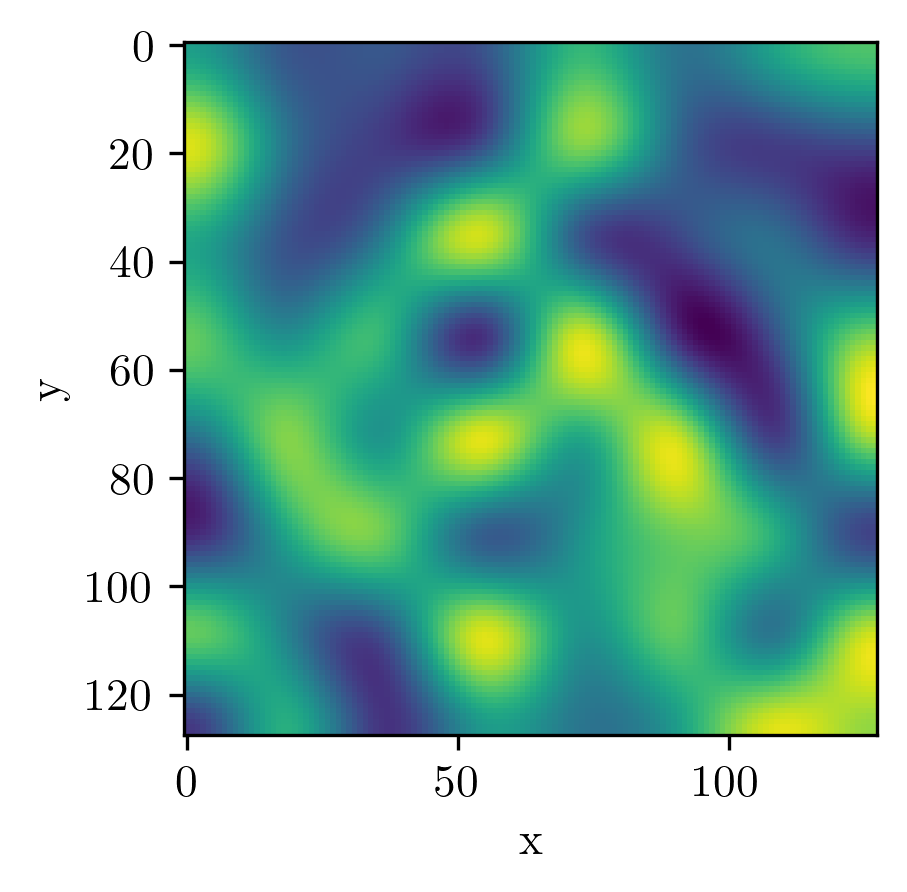

In [ ]:
def generate_heatmap(features = 8, zoom = 16):
  heatmap = np.random.random((features,features))-0.5
  large_heatmap = scipy.ndimage.zoom(heatmap, zoom)
  return large_heatmap

large_heatmap = generate_heatmap()
plt.imshow(large_heatmap)
plt.xlabel("x")
plt.ylabel("y")
plt.grid()


## Generating the brush

In [ ]:
def circular_brush(diameter):
    radius = diameter / 2
    X, Y = np.mgrid[-radius : radius : 1j * diameter, -radius : radius : 1j * diameter]
    _int = lambda x: np.array(x, dtype=int)
    brush = _int(X) ** 2 + _int(Y) ** 2 < radius ** 2
    return brush

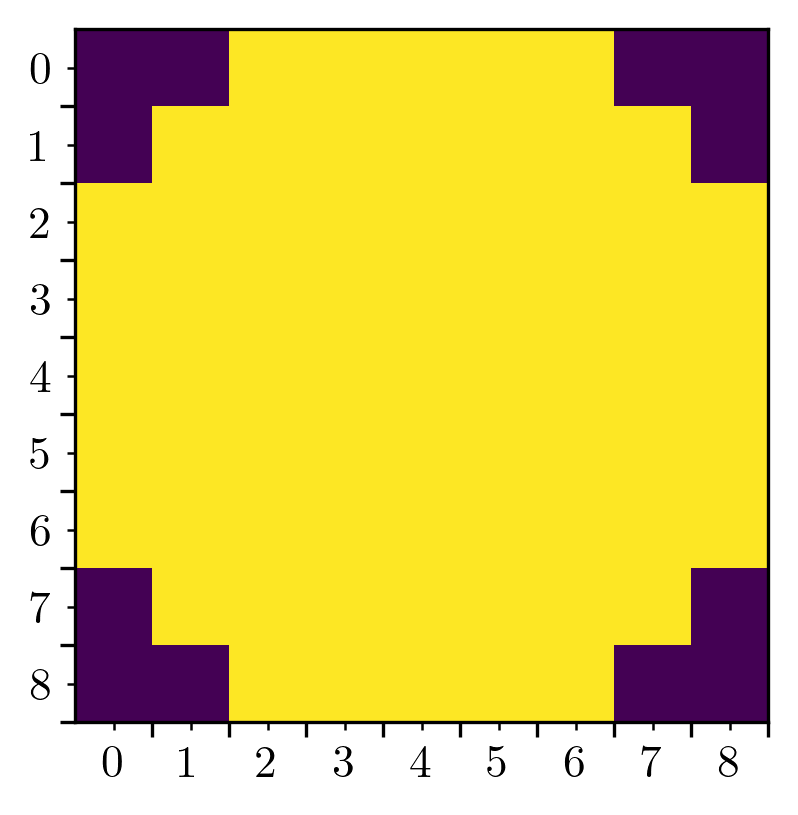

In [ ]:
kernel_size=9
brush = np.ones((kernel_size, kernel_size))
brush[0,0] = 0
brush[0,-1] = 0
brush[-1,0] = 0
brush[-1,-1] = 0

brush = circular_brush(kernel_size)
brush = brush.astype(bool)

def show_brush(brush):
  nx, ny = brush.shape
  plt.imshow(brush)
  ax = plt.gca()
  ax.set_yticks(np.arange(nx)+0.5)
  ax.set_yticklabels(["" for i in range(nx)])
  ax.set_xticks(np.arange(ny)+0.5)
  ax.set_xticklabels(["" for i in range(ny)])
  ax.set_yticks(np.arange(nx), minor=True)
  ax.set_yticklabels([f"{i}" for i in range(nx)], minor=True)
  ax.set_xticks(np.arange(ny), minor=True)
  ax.set_xticklabels([f"{i}" for i in range(ny)], minor=True)
  plt.grid()

show_brush(brush)

<matplotlib.colorbar.Colorbar>

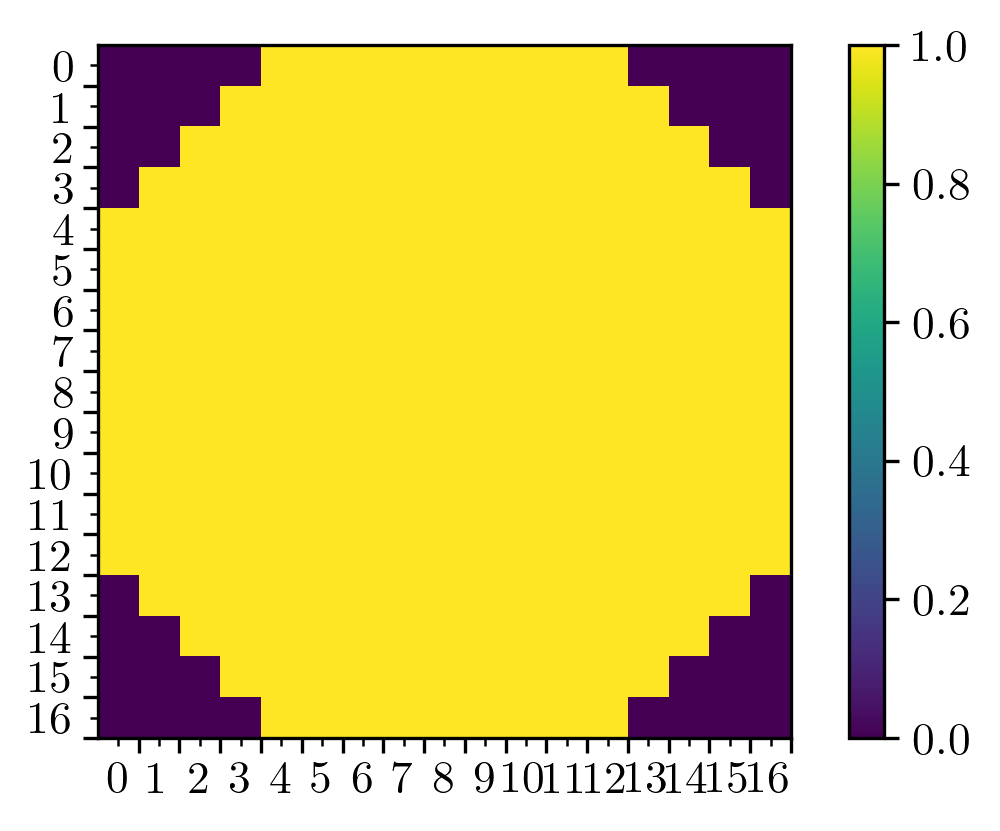

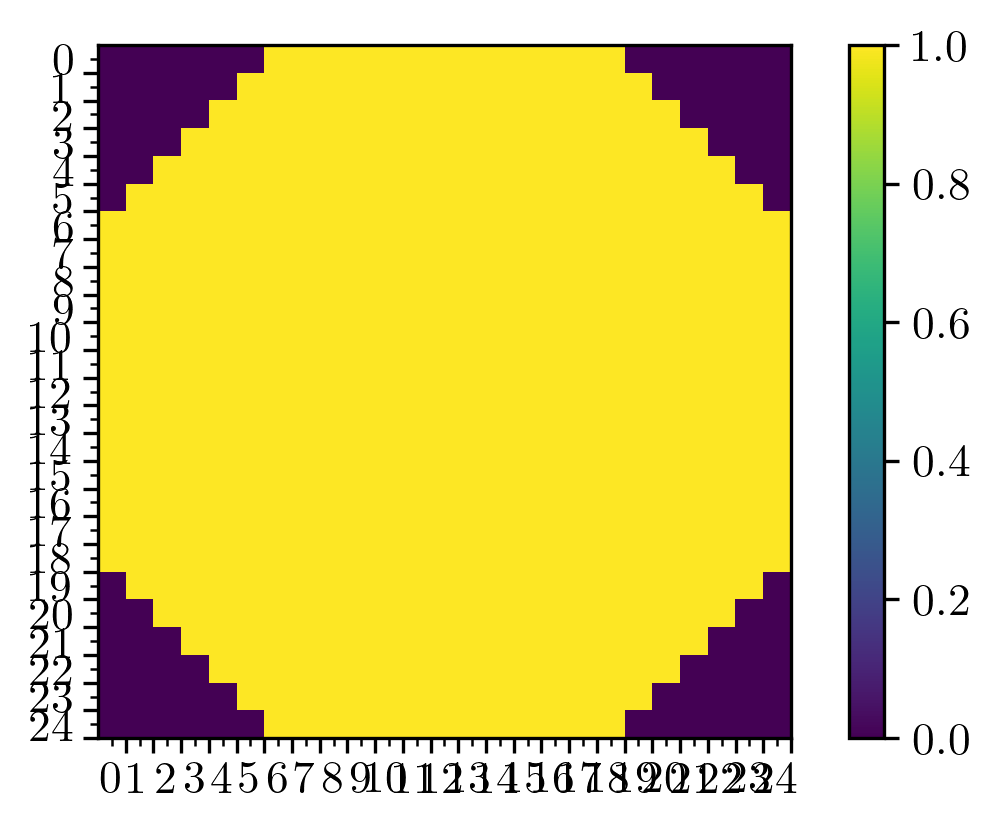

In [ ]:
conv_brush = scipy.ndimage.binary_dilation(np.pad(brush, len(brush)//2), brush)
show_brush(conv_brush)
plt.colorbar()

plt.figure()
double_conv_brush = scipy.ndimage.binary_dilation(np.pad(conv_brush, len(brush)//2), brush)
show_brush(double_conv_brush)
plt.colorbar()

## Running the Generator

In [ ]:
#| export
def dilate(img, brush, count_time=True):
  try:
    if count_time:
      global times
      times.dilate -= time.process_time() 
  
    dil = scipy.ndimage.binary_dilation(img, brush)
    if count_time:
      times.dilate += time.process_time() 
  except NameError:
    dil = scipy.ndimage.binary_dilation(img, brush)
  return dil

In [ ]:
#| export
class GeneratorState():

  def __init__(self, heatmap, brush) -> None:
    self.brush = brush.copy()
    self.dil_brush = dilate(np.pad(brush, len(brush)//2), brush, False) # dilated brush
    self.dil2_brush = dilate(np.pad(self.dil_brush, len(brush)//2), brush, False) # doubly dilated brush
    self.dil3_brush = dilate(np.pad(self.dil2_brush, len(brush)//2), brush, False)
    self.dil4_brush = dilate(np.pad(self.dil3_brush, len(brush)//2), brush, False)

    self.s_suggest = heatmap.copy()
    self.v_suggest = heatmap.copy()

    zero = np.zeros_like(heatmap).astype(bool)
    one  = np.ones_like(heatmap).astype(bool)
    self.t_s            = zero.copy() # solid touches
    self.t_v            = zero.copy() # void touches
    self.t_s_free       = zero.copy() 
    self.t_v_free       = zero.copy() 
    self.t_s_resolving  = zero.copy() 
    self.t_v_resolving  = zero.copy() 
    self.p_s_required   = zero.copy() 
    self.p_v_required   = zero.copy() 
    self.p_s_existing   = zero.copy()
    self.p_v_existing   = zero.copy()
    self.t_s_impossible = zero.copy()
    self.t_v_impossible = zero.copy()
    self.t_s_valid      = one.copy()
    self.t_v_valid      = one.copy()
    self.p_s_possible   = one.copy()
    self.p_v_possible   = one.copy()
    
    self.dilated_p_s_possible = one.copy()
    self.dilated_p_v_possible = one.copy()

    self.dilated_p_s_required = zero.copy()
    self.dilated_p_v_required = zero.copy()
    
  def show(self):
    plt.figure(figsize = (6,6))
    plt.subplot(121)
    plt.title("Solid")
    plt.imshow(self.p_s_existing, vmin=0, vmax=1)
    plt.subplot(122)
    plt.title("Solid and Void Touches")
    plt.imshow(self.t_s.astype(int)-self.t_v)
@dataclass
class Times():
  update          :float = 0
  dilate          :float = 0 # includes local dilate
  required        :float = 0
  resolving       :float = 0
  select          :float = 0 
  convolute       :float = 0
  existing        :float = 0
  impossible      :float = 0
  possible        :float = 0
  valid           :float = 0
  free            :float = 0
  local_required  :float = 0
  local_resolving :float = 0
  local_dilate    :float = 0

In [ ]:
#| export
debug = 1

In [ ]:
#| export
def log(*args, level=1):
  if debug>=level:
    print(*args)

In [ ]:
#| exporti
def existing_pixels(touches, brush):
    return dilate(touches, brush)

def impossible_touches(existing_other, brush):
    return dilate(existing_other, brush)

def valid_touches(impossible, touches):
    return np.logical_and(np.logical_not(impossible), np.logical_not(touches))

def possible_pixels(valid, touches, brush): # only used for debugging
    possible_touches = np.logical_or(touches, valid)
    # equivalent to touches or (not impossible)
    # because all touches must be possible: it is simply equivalent to not impossible.
    return dilate(possible_touches, brush)

def required_pixels(existing, possible_other):
    # from a free touch existing gets bigger, while possible other is unchanged
    return np.logical_and(np.logical_not(existing), np.logical_not(possible_other))

def resolving_touches(required, valid, brush): # TODO avoid dilation in all cases
    #instead of using valid we might consider using not impossible here? 
    #-> not helpful, as we need valid for free anyways
    return resolving_touches_no_dilate(dilate(required, brush), valid)

def resolving_touches_no_dilate(dilated_required, valid):
  return np.logical_and(dilated_required, valid)

def free_touches(possible_other, valid, brush): # only used for debugging
  # np.logical_or(existing_other) not needeed, as every existing pixel is a possible pixel
  # no need to calculate free touches after a free touch as there will be none
    dilated = dilate(possible_other, brush)
    return free_touches_no_dilate(dilated, valid)

def free_touches_no_dilate(dilated, valid):
    return np.logical_and(np.logical_not(dilated), valid)

In [ ]:
def compare(s_try, s_actual, v_try, v_actual, name):
  """
  Compares properties of a new implementation and the original slow one.
  Raises Error if they are not equal and plots the comparison
  """
  compare_s = np.logical_xor(s_try,s_actual)
  compare_v = np.logical_xor(v_try,v_actual)

  if compare_s.any() or compare_v.any():
    plt.figure(figsize = (6,9))
    plt.subplot(321)
    plt.title("Compare Solid")
    plt.imshow(compare_s, vmax=1, vmin=0)
    plt.subplot(322)
    plt.title("Compare Void")
    plt.imshow(compare_v, vmax=1, vmin=0)
    plt.subplot(323)
    plt.title(f"{name} Solid")
    plt.imshow(s_try, vmax=1, vmin=0)
    plt.subplot(324)
    plt.title(f"{name} Void")
    plt.imshow(v_try, vmax=1, vmin=0)
    plt.subplot(325)
    plt.title(f"Actual {name} Solid")
    plt.imshow(s_actual, vmax=1, vmin=0)
    plt.subplot(326)
    plt.title(f"Actual {name} Void")
    plt.imshow(v_actual, vmax=1, vmin=0)
    plt.show()
    raise ValueError(f"Calculation of {name} wrong")

def check_valid(state: GeneratorState):
  if debug>2:
    times.possible -= time.process_time() 
    p_s_possible_real = possible_pixels(state.t_s_valid,state.t_s,brush)
    p_v_possible_real = possible_pixels(state.t_v_valid,state.t_v,brush)
    times.possible += time.process_time() 
    compare(state.p_s_possible,p_s_possible_real, state.p_v_possible,p_v_possible_real, "possible")

  if debug>2:
    p_s_possible_dilated_real = dilate(state.p_s_possible, state.brush, False)
    p_v_possible_dilated_real = dilate(state.p_v_possible, state.brush, False)
    compare(state.dilated_p_s_possible,p_s_possible_dilated_real, state.dilated_p_v_possible,p_v_possible_dilated_real, "dilated possible")

    t_s_free_real = free_touches(state.p_v_possible, state.t_s_valid, state.brush)
    t_v_free_real = free_touches(state.p_s_possible, state.t_v_valid, state.brush)
    compare(state.t_s_free,t_s_free_real, state.t_v_free,t_v_free_real, "free")

  if debug>1:
    t_s_valid_real = valid_touches(state.t_s_impossible, state.t_s)
    t_v_valid_real = valid_touches(state.t_v_impossible, state.t_v)
    compare(state.t_s_valid, t_s_valid_real, state.t_v_valid, t_v_valid_real, "valid")

  if state.t_s_free.any() or state.t_v_free.any():
    return

  if debug>1:
    p_s_required_real = required_pixels(state.p_s_existing, state.p_v_possible)
    p_v_required_real = required_pixels(state.p_v_existing, state.p_s_possible)
    compare(state.p_s_required,p_s_required_real, state.p_v_required,p_v_required_real, "required")
  
  if debug>1:
    p_s_required_dilated_real = dilate(state.p_s_required, state.brush)
    p_v_required_dilated_real = dilate(state.p_v_required, state.brush)
    compare(state.dilated_p_s_required, p_s_required_dilated_real, state.dilated_p_v_required, p_v_required_dilated_real, "dilated required")

    t_s_resolving_real = resolving_touches(state.p_s_required, state.t_s_valid, state.brush)
    t_v_resolving_real = resolving_touches(state.p_v_required, state.t_v_valid, state.brush)
    compare(state.t_s_resolving,t_s_resolving_real, state.t_v_resolving,t_v_resolving_real, "resolving")

In [ ]:
#| export
def select_single(s_valid, v_valid, state):
    global times
    times.convolute -= time.process_time() 
    s_weights = scipy.ndimage.convolve(state.s_suggest, state.brush) # TODO eliminate this convolution!
    v_weights = -scipy.ndimage.convolve(state.v_suggest, state.brush)
    times.convolute += time.process_time() 

    s_weights[np.logical_not(s_valid)] = np.nan
    v_weights[np.logical_not(v_valid)] = np.nan

    max_s = max_v = -np.inf
    if s_valid.any():
        max_pos_s = np.nanargmax(s_weights)
        max_s = s_weights.flat[max_pos_s]
    
    if v_valid.any():
        max_pos_v = np.nanargmax(v_weights)
        max_v = v_weights.flat[max_pos_v]

    if  max_s > max_v:
      touch(max_pos_s, state, solid=True)
    else:
      touch(max_pos_v, state, solid=False)

def touch(flat_index: int, state: GeneratorState, solid: bool, track_possible: bool=True):
  """Perform a touch on the given index of the flattened map and track the consequences"""
  if solid:
    touches               = state.t_s
    existing              = state.p_s_existing
    other_impossible      = state.t_v_impossible
    other_possible_pixels = state.p_v_possible
  else:
    touches               = state.t_v
    existing              = state.p_v_existing
    other_impossible      = state.t_s_impossible
    other_possible_pixels = state.p_s_possible

  touches.flat[flat_index] = True
  track(existing, flat_index, state.brush)
  track(other_impossible, flat_index, state.dil_brush)

  if track_possible:
    if debug>3:
      plt.figure(figsize = (6,6))
      plt.subplot(221)
      plt.title("Possible Pixels before")
      plt.imshow(other_possible_pixels,  vmax=1, vmin=0)
      idx = np.unravel_index(flat_index, other_possible_pixels.shape)
      plt.scatter([idx[1]],[idx[0]], s=1)
      plt.imshow(touches,  vmax=1, vmin=0, alpha=0.3*touches, cmap="jet")

    track(other_possible_pixels, flat_index, state.dil2_brush, invert=True)
    
    if debug>3:
      plt.subplot(222)
      plt.title("Possible Pixels penalized")
      plt.imshow(other_possible_pixels,  vmax=1, vmin=0)
      idx = np.unravel_index(flat_index, other_possible_pixels.shape)
      plt.scatter([idx[1]],[idx[0]], s=1)
      plt.imshow(touches,  vmax=1, vmin=0, alpha=0.3*touches, cmap="jet")

    local_dilate(np.logical_not(other_impossible), flat_index, state.brush, other_possible_pixels)
    
    times.valid -= time.process_time() 
    state.t_s_valid = valid_touches(state.t_s_impossible, state.t_s)
    state.t_v_valid = valid_touches(state.t_v_impossible, state.t_v)
    times.valid += time.process_time() 

    times.free -= time.process_time() 
    if solid:
      track(state.dilated_p_v_possible, flat_index, state.dil3_brush, invert=True)
      local_dilate(state.p_v_possible, flat_index, state.brush, 
        state.dilated_p_v_possible, l=len(state.brush)*3, plot=debug>3)
      state.t_s_free = free_touches_no_dilate(state.dilated_p_v_possible, state.t_s_valid)
    else:
      track(state.dilated_p_s_possible, flat_index, state.dil3_brush, invert=True)
      local_dilate(state.p_s_possible, flat_index, state.brush, 
        state.dilated_p_s_possible, l=len(state.brush)*3, plot=debug>3)
      state.t_v_free = free_touches_no_dilate(state.dilated_p_s_possible, state.t_v_valid)
    times.free += time.process_time() 

    times.local_required -= time.process_time() 
    state.p_s_required = required_pixels(state.p_s_existing, state.p_v_possible)
    state.p_v_required = required_pixels(state.p_v_existing, state.p_s_possible)
    times.local_required += time.process_time()

    times.local_resolving -= time.process_time() 
    track(state.dilated_p_s_required, flat_index, state.dil4_brush, invert=True)
    track(state.dilated_p_v_required, flat_index, state.dil4_brush, invert=True)

    if debug>2:
      plt.figure()
      plt.subplot(121)
      plt.title("Required S")
      plt.imshow(state.p_s_required, vmax=1, vmin=0)
      plt.subplot(122)
      plt.imshow(state.p_v_required, vmax=1, vmin=0)

    local_dilate(state.p_s_required, flat_index, state.brush, 
      state.dilated_p_s_required, l=len(state.brush)*4, plot=debug>1, plot_name="required s")
    local_dilate(state.p_v_required, flat_index, state.brush, 
      state.dilated_p_v_required, l=len(state.brush)*4, plot=debug>1, plot_name="required v")
    state.t_s_resolving = resolving_touches_no_dilate(state.dilated_p_s_required, state.t_s_valid)
    state.t_v_resolving = resolving_touches_no_dilate(state.dilated_p_v_required, state.t_v_valid)
    times.local_resolving += time.process_time() 
      #update_resolving(state)

def local_dilate(img, pos, brush, res, l=None, grow=True, plot=False, plot_name=""):
  times.local_dilate -= time.process_time() 
  if l is None:
    l = len(brush)*2
  
  idx = np.unravel_index(pos, img.shape)
  
  dw = [min(l, idx_i) for idx_i in idx] #from the brushcenter how many pixels "down" the axis
  up = [min(l+1, max(l_img - idx_i, 0)) for (idx_i, l_img) in zip(idx, img.shape)]

  log("up_down:", up, dw, level=2)

  slice_image = np.s_[
    idx[0]-dw[0]:idx[0]+up[0], 
    idx[1]-dw[1]:idx[1]+up[1]
  ]

  if grow:
    res[slice_image] |= dilate(img[slice_image], brush, False)
  else:
    res[slice_image] &= dilate(img[slice_image], brush, False)
  times.local_dilate += time.process_time() 

  if plot:
    plt.figure(figsize = (6,3))
    plt.subplot(121)
    plt.title(f"{plot_name} Dilated From")
    plt.imshow(img, vmax=1, vmin=0)
    plt.subplot(122)
    plt.title(f"{plot_name} Dilated To")
    plt.imshow(res, vmax=1, vmin=0)
  

def track(img, pos, brush, invert=False):
  l = len(brush)//2
  idx = np.unravel_index(pos, img.shape)

  # slightly complicated :/
  dw = [min(l, idx_i) for idx_i in idx] #from the brushcenter how many pixels "down" the axis
  up = [min(l+1, max(l_img - idx_i, 0)) for (idx_i, l_img) in zip(idx, img.shape)]
  slice_image = np.s_[
    idx[0]-dw[0]:idx[0]+up[0], 
    idx[1]-dw[1]:idx[1]+up[1]
  ]
  slice_brush = np.s_[
    l -dw[0]:l+up[0],
    l -dw[1]:l+up[1],
  ]
  if not invert:
    img[slice_image] |= brush[slice_brush]
  else:
    img[slice_image] &= ~brush[slice_brush]

def update_resolving(state):

  times.required -= time.process_time() 
  state.p_s_required = required_pixels(state.p_s_existing, state.p_v_possible)
  state.p_v_required = required_pixels(state.p_v_existing, state.p_s_possible)
  times.required += time.process_time() 

  times.resolving -= time.process_time() 
  state.dilated_p_s_required=dilate(state.p_s_required, state.brush)
  state.dilated_p_v_required=dilate(state.p_v_required, state.brush)

  state.t_s_resolving = resolving_touches_no_dilate(state.dilated_p_s_required, state.t_s_valid)
  state.t_v_resolving = resolving_touches_no_dilate(state.dilated_p_v_required, state.t_v_valid)
  times.resolving += time.process_time() 

def force_update(state):
  state.p_s_existing = existing_pixels(state.t_s, state.brush)
  state.p_v_existing = existing_pixels(state.t_v, state.brush)

  state.t_s_impossible = impossible_touches(state.p_v_existing, state.brush)
  state.t_v_impossible = impossible_touches(state.p_s_existing, state.brush)

  state.t_s_valid = valid_touches(state.t_s_impossible, state.t_s)
  state.t_v_valid = valid_touches(state.t_v_impossible, state.t_v)

  state.p_s_possible = possible_pixels(state.t_s_valid,state.t_s,state.brush)
  state.p_v_possible = possible_pixels(state.t_v_valid,state.t_v,state.brush) 

  state.p_s_required = required_pixels(state.p_s_existing, state.p_v_possible)
  state.p_v_required = required_pixels(state.p_v_existing, state.p_s_possible)

  state.t_s_resolving = resolving_touches(state.p_s_required, state.t_s_valid, state.brush)
  state.t_v_resolving = resolving_touches(state.p_v_required, state.t_v_valid, state.brush)

  state.t_s_free = free_touches(state.p_v_possible, state.t_s_valid, state.brush)
  state.t_v_free = free_touches(state.p_s_possible, state.t_v_valid, state.brush)

def generate(
    heatmap, # the latent space representation
    brush,  # the brush, determining the fabrication constraints
    t_s:np.ndarray=None, # initial touches for the solid
    t_v:np.ndarray=None  # initial touches for the void
  ):

  state = GeneratorState(heatmap, brush) # pregenerates the dilated brushes
  init_set = False
  if t_s is not None:
    state.t_s = t_s.copy()
    init_set=True
  if t_v is not None:
    state.t_v = t_v.copy()
    init_set=True
  if init_set:
    force_update(state)

  #state.show()

  global times # not beautiful remove

  for i in range(np.prod(heatmap.shape)): #N**2
    times.update -= time.process_time() 
    ### Update
    state.s_suggest[state.p_s_existing] = 0
    state.v_suggest[state.p_v_existing] = 0

    if debug>1:
      check_valid(state)

    times.update += time.process_time() 

    ### Select
    times.select -= time.process_time() 
    if state.t_s_free.any() or state.t_v_free.any():
      log(f"{i}: free: {state.t_s_free.sum()}; {state.t_v_free.sum()}")

      flat_free_s = np.where(state.t_s_free.flatten())[0]
      flat_free_v = np.where(state.t_v_free.flatten())[0]
      
      times.existing -= time.process_time() 
      for idx in flat_free_s:
        touch(idx, state, solid=True, track_possible=False) #no change to possible
      
      for idx in flat_free_v:
        touch(idx, state, solid=False, track_possible=False)
      times.existing += time.process_time() 

      times.valid -= time.process_time() 
      state.t_s_valid = valid_touches(state.t_s_impossible, state.t_s)
      state.t_v_valid = valid_touches(state.t_v_impossible, state.t_v)
      times.valid += time.process_time() 
      times.select += time.process_time()

      times.update -= time.process_time()
      update_resolving(state)
      times.update += time.process_time() 
      
      times.select -= time.process_time() 
      state.t_s_free[:] = False
      state.t_v_free[:] = False

    elif state.t_s_resolving.any() or state.t_v_resolving.any():
      log(f"{i}: resolving")
      select_single(state.t_s_resolving, state.t_v_resolving, state)
    elif state.t_s_valid.any() or state.t_v_valid.any():
      log(f"{i}: valid")
      select_single(state.t_s_valid, state.t_v_valid, state)
    else:
      log("finished")
      times.select += time.process_time() 
      break

    times.select += time.process_time() 
      
  if debug>0:
    state.show()

  return state
  

In [ ]:
#| exporti
from inverse_design.design import design_mask, Design, PIXEL_EXISTING, TOUCH_EXISTING
import jax
import jax.numpy as jnp

In [ ]:
#| export
def generate_feasible_design(latent_t, brush,
  init_touches_solid = None, 
  init_touches_void = None,
  verbose=False
  ):

    design = None
    global debug
    debug = 1 if verbose else 0

    global times
    times = Times()
    state = generate(
      np.array(latent_t), 
      np.array(brush), 
      np.array(init_touches_solid) if init_touches_solid is not None else None, #Ugly
      np.array(init_touches_void) if init_touches_void is not None else None
    )
    return Design(
      void_pixels=state.p_v_existing*PIXEL_EXISTING, 
      solid_pixels=state.p_s_existing*PIXEL_EXISTING,
      void_touches=state.t_v*TOUCH_EXISTING,
      solid_touches=state.t_s*TOUCH_EXISTING
    )


In [ ]:
#| export
@jax.custom_jvp
def generate_feasible_design_mask(
    latent_t, 
    brush,
    init_touches_solid = None, 
    init_touches_void = None, 
    verbose=False
  ): #
    #print("evaluating fn")
    design = generate_feasible_design(
      latent_t, 
      brush, 
      init_touches_solid=init_touches_solid, 
      init_touches_void=init_touches_void,
      verbose=verbose)
    return design_mask(design)

In [ ]:
#| export
@generate_feasible_design_mask.defjvp
def generate_feasible_design_mask_jvp(primals, tangents):
  return primals[0], tangents[0]  # identity function for first argument: latent_t

In [ ]:
times = Times()
debug=0
generate(large_heatmap, brush)

<__main__.GeneratorState>

### Times for 128 sidelength
No tracking: 6.94s

With partial tracking of existing: 6.09s

With full tracking of existing: 5.72s

With tracking of existing, impossible touches and possible pixels: 3.77s

In [ ]:
times.__dict__

{'update': 0.8994090000000554,
 'dilate': 0.8653919999999999,
 'required': 0.003246999999966249,
 'resolving': 0.8722770000000679,
 'select': 1.5143769999997048,
 'convolute': 0.7212829999999713,
 'existing': 0.15831899999997034,
 'impossible': 0,
 'possible': 0,
 'valid': 0.009262000000070714,
 'free': 0.07210700000011627,
 'local_required': 0.005159000000013236,
 'local_resolving': 0.33620400000000217,
 'local_dilate': 0.44979300000013467}

In [ ]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

debug=0
df = []
for features in tqdm([2, 4, 8, 10, 12, 13, 14, 15, 16, 17, 18], desc="features", position=0):
  
  for i in tqdm(range(50//features), desc="iteration", position=1, leave=False):
    heatmap = generate_heatmap(features, zoom=16)
    times = Times()
    generate(heatmap)
    dic = times.__dict__
    dic["features"] = features
    df.append(dic)

df = pd.DataFrame(df)

In [ ]:
#df.to_pickle("timing.pkl")

In [ ]:
df = pd.read_pickle("../resources/timing.pkl")

In [ ]:
df["pixels"] = df["features"]**2*16**2
df["total"] = df["update"]+df["select"]
linear = ["local_dilate", "local_required", "local_resolving", "existing", "impossible", "possible", "valid", "free"]
df["linear_ops"] = df[linear].sum(axis="columns")
exclude = ["features", "required", "update+select", "features_sq", "update", "select"]
df = df.drop(columns=exclude)

t_mean = df.groupby("pixels").agg(np.mean)
t_std = df.groupby("pixels").agg(np.std)

In [ ]:
def plot_timing(t_mean, t_std):
  for ((col_mean,val_mean), (col_std, val_std)) in zip(t_mean.items(), t_std.items()):
      plt.errorbar(val_mean.index, val_mean, val_std*2, label=col_mean)
      #t_mean.drop(columns=linear).plot(y="mean", yerr="std")
      plt.ylabel("Time [s]")
      plt.xlabel("Number Pixels")

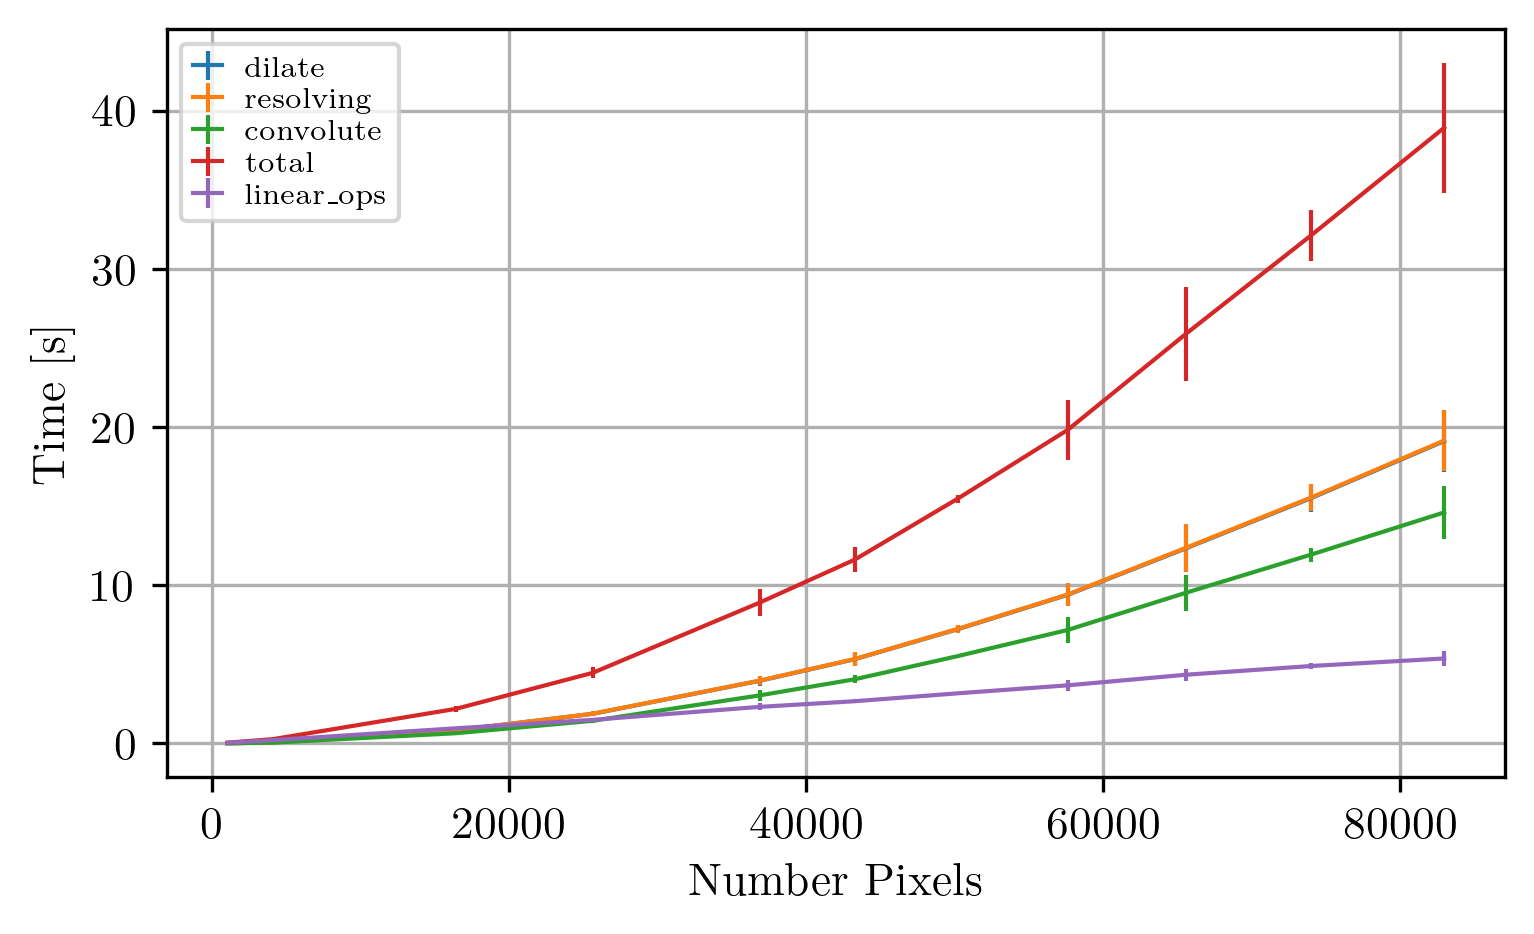

In [ ]:
plt.figure(constrained_layout=True)
plot_timing(t_mean.drop(columns=linear), t_std.drop(columns=linear))
plt.legend()
plt.savefig("total_time.png")

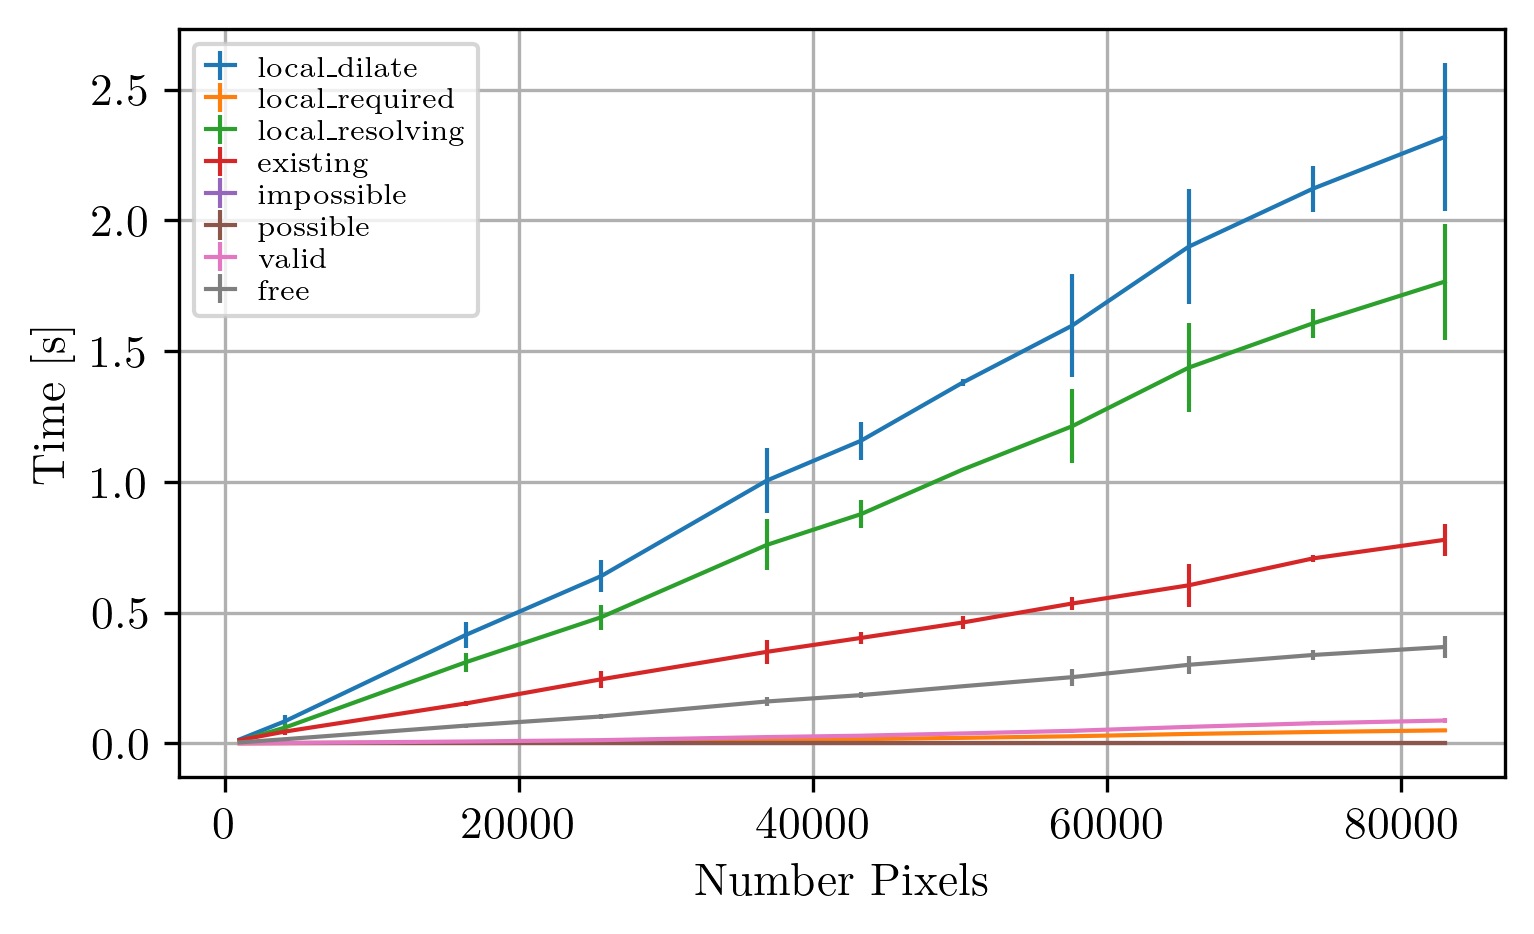

In [ ]:
plt.figure(constrained_layout=True)
plot_timing(t_mean[linear], t_std[linear])
plt.legend()
plt.savefig("linear_time.png")